# Imports

In [1]:
import mdtraj as md
import MDAnalysis as mda
import numpy as np
import pandas as pd
import encodermap as em
import loading_lizard as ll
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import nglview as ngl
import xarray as xr
import networkx as nx
import expansion_elephant as ep
import tensorflow as tf
import running_rabbit as rr

import xplor

rr.update_gmx_environ('2021.1', cuda=True, AVX512=False)

import glob, os, re, sys, copy, pickle, hdbscan, subprocess, itertools, pathlib, pyemma, shutil, time, ast

from pprint import pprint
from io import StringIO

sys.path.insert(0, '/home/kevin/git/Backward/')
import backward

%matplotlib notebook
%load_ext autoreload
%autoreload 2

/home/kevin/projects/encoder_map_private/encodermap/loading/features.py:36: UserWarning: Features need Unittests
  warnings.warn("Features need Unittests")


Also disabling gmx quotes
sourcing /home/soft/gromacs/gromacs-2021.1/inst/cuda_shared_20.04/bin/GMXRC.bash ...


# Trace back simulation origin

In [2]:
rr.paramiko.SSHClient('scc2.uni-konstanz.de', 'kevin')

Please enter passphrase for user `kevin@scc2.uni-konstanz.de`: ········


In [3]:
rr.paramiko.ls('/data/scc3/andrejb/ARCHIVE/simulations/2017_06_09_GfM_SMmin_2ub_k6_01/')

['backmap',
 'confout.gro',
 'diUBQ.338931',
 'ener.edr',
 'md.log',
 'meta.dat',
 'preproc',
 'run.gro',
 'run.mdp',
 'state.cpt',
 'state_prev.cpt',
 'submit.sh',
 'system.top',
 'topol.tpr',
 'traj_comp.xtc',
 'traj.trr']

In [143]:
with rr.paramiko.SCPTempFile('/data/scc3/andrejb/ARCHIVE/simulations/2017_04_27_G_2ub_k6_01_01/topol.tpr', client_kwargs={'url': 'scc2.uni-konstanz.de', 'username': 'kevin'}) as tpr_file:
    print(tpr_file)

/home/kevin/projects/tobias_schneider/tmp.tpr


In [5]:
def is_aa_sim(file):
    directory = '/'.join(file.split('/')[:-1])
    contents = os.listdir(directory)
    gro_file = os.path.join(directory, 'start.gro')
    with open(gro_file, 'r') as f:
        content = f.read()
    if 'MARTINI' in content:
        return False
    elif 'Protein in water' in content:
        return True
    else:
        print(content)
        raise Exception("Can not decide whether sim is AA or CG.")
        

def truncate_before_ubq(ubq_sites):
    def closure(string):
        for ubq_site in ubq_sites:
            if ubq_site in string:
                return string.split(ubq_site)[0].strip('_')
        else:
            print(string)
            raise Exception("STOP")
    return closure
    
        
def count_groups(prefixes, full_names):
    substring_counts = {}
    files = {}
    
    for i, j in zip(prefixes, full_names):
        if i in substring_counts:
            substring_counts[i] += 1
            files[i].append(j)
        else:
            substring_counts[i] = 1
            files[i] = [j]
                
    return substring_counts, files

In [6]:
xtc_files = []
ubq_sites = ['k6', 'k29']
for ubq_site in ubq_sites:
    xtc_files.extend(glob.glob(f"/home/andrejb/Research/SIMS/*{ubq_site}_*/traj_nojump.xtc"))

filtered_files = []
dirs = set()

for xtc_file in xtc_files:
    dir_ = xtc_file.split('/')[-2]
    if not dir_ in dirs and is_aa_sim(xtc_file):
        filtered_files.append(xtc_file)
    dirs.add(dir_)
pprint(filtered_files)

['/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_01/traj_nojump.xtc',
 '/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_02/traj_nojump.xtc',
 '/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_03/traj_nojump.xtc',
 '/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_04/traj_nojump.xtc',
 '/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_05/traj_nojump.xtc',
 '/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_06/traj_nojump.xtc',
 '/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_02_01/traj_nojump.xtc',
 '/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_02_02/traj_nojump.xtc',
 '/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_02_03/traj_nojump.xtc',
 '/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_02_04/traj_nojump.xtc',
 '/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_02_05/traj_nojump.xtc',
 '/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_02_06/traj_nojump.xtc',
 '/home/andrejb/Research/SIMS/2017_06_09_GfM_SMmin_2ub_k6_01/traj_nojump.xtc',
 '/home/andrejb/Research/SIMS/201

In [7]:
truncated_list = list(map(truncate_before_ubq(ubq_sites), filtered_files))
counts, filecounts = count_groups(truncated_list, filtered_files)

In [146]:
rr.paramiko.SSHClient('scc2.uni-konstanz.de', 'kevin')

Please enter passphrase for user `kevin@scc2.uni-konstanz.de`: ········


<IPython.core.display.Javascript object>


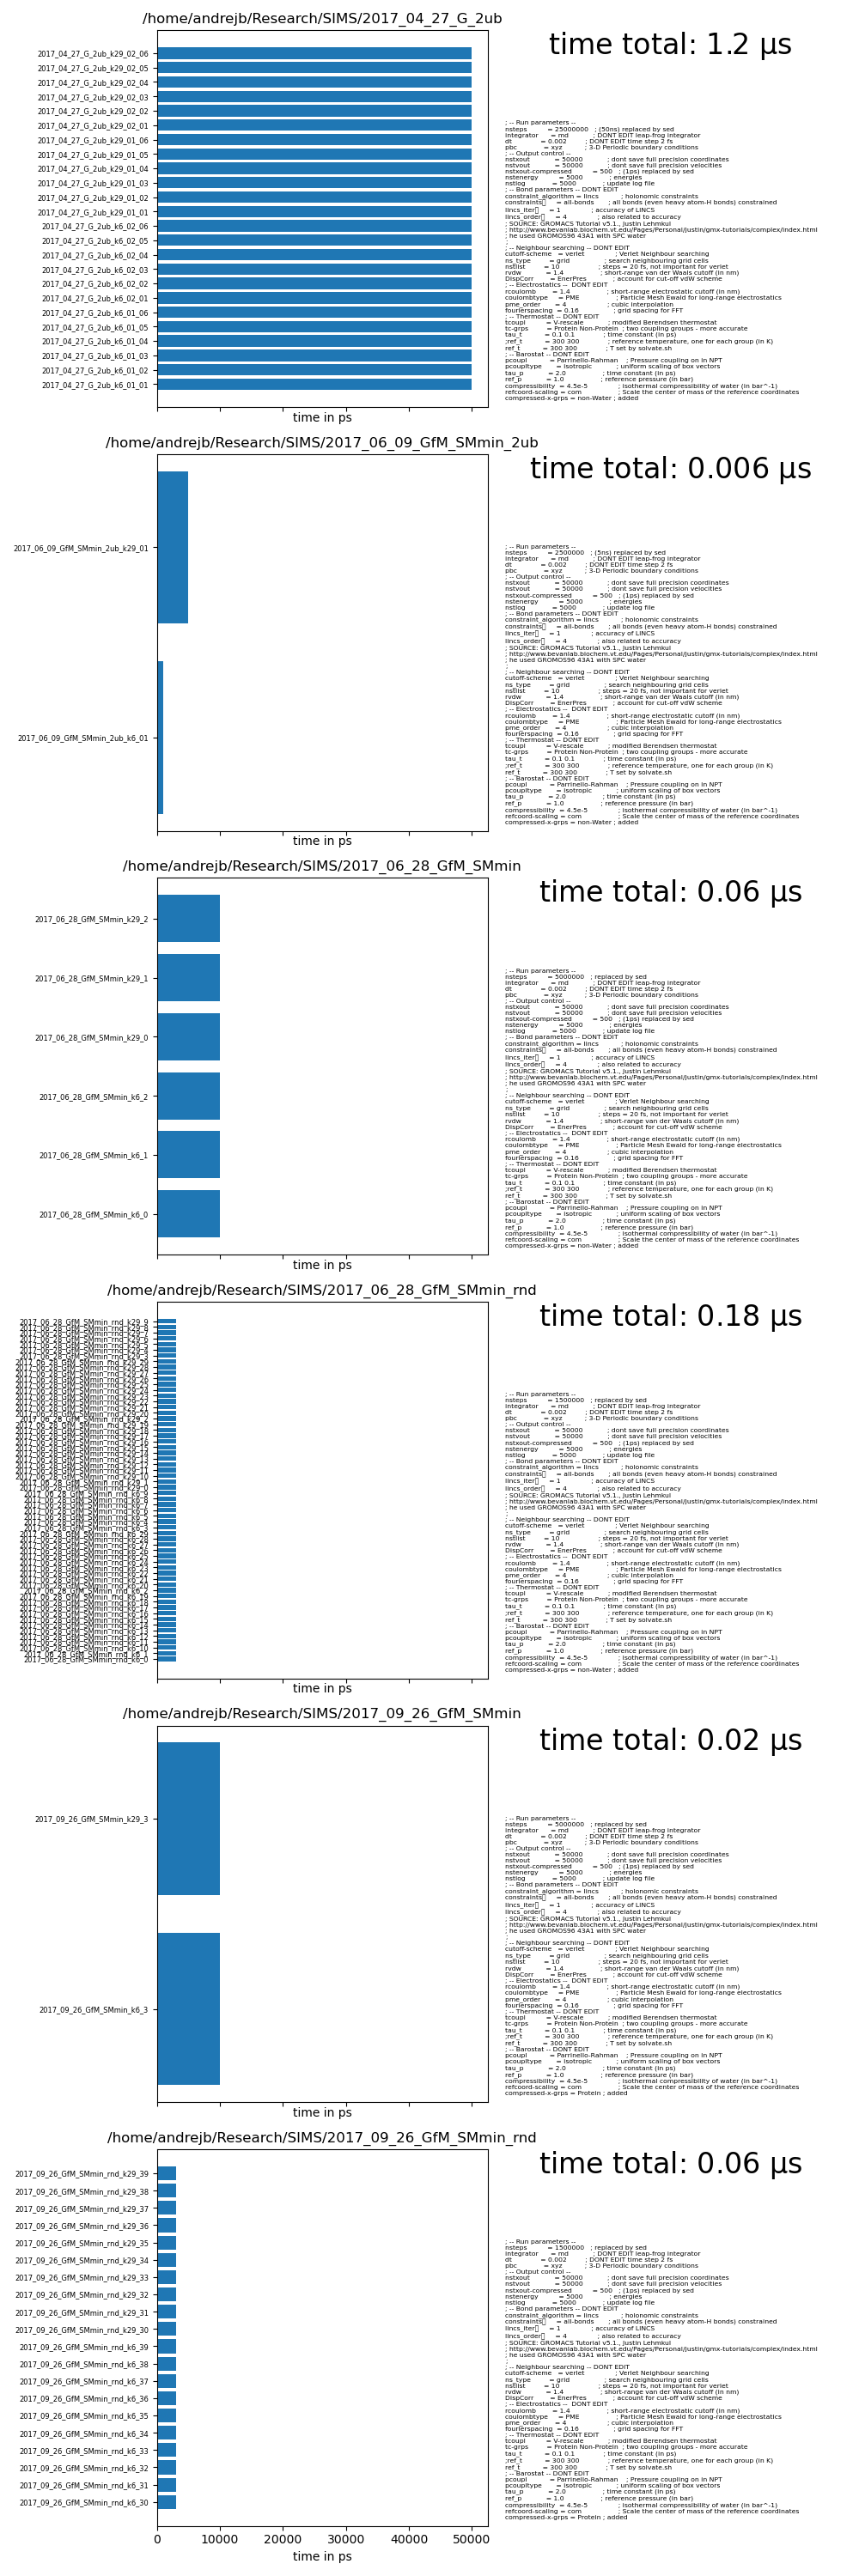

/home/kevin/.conda/envs/tf2_38/lib/python3.8/site-packages/matplotlib/backends/_backend_pdf_ps.py:102: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)


In [45]:
plt.close('all')

factors = {'ps': 1, 'ns': 1000}

square_figsize = np.array([5, 5])
nrows = len(counts.keys())
ncols = 2
figsize = tuple(square_figsize * np.array([ncols, nrows]))

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize, sharex='col')

for i, (substring, files) in enumerate(filecounts.items()):
    bar_lengths = []
    ids = []
    df = pd.DataFrame({})
    sum_time = 0
    for j, file in enumerate(files):
        xtc = mda.coordinates.XTC.XTCReader(file)
        if xtc.units['time'] not in factors:
            raise Exception(f"{xtc.units} not in factors")
        totaltime = factors[xtc.units['time']] * xtc.totaltime
        sum_time += totaltime
        bar_lengths.append(totaltime)
        id_ = file.split('/')[-2]
        ids.append(id_)
            
        remote_run = f'/data/scc3/andrejb/ARCHIVE/simulations/{id_}/run.mdp'
        with rr.paramiko.SCPTempFile(remote_run) as f:
            with open(f, 'r') as _:
                content = _.read()
        if j == 0:
            df = pd.read_csv(StringIO(content.replace('\t', '')), delimiter='=', comment=';', index_col=0, names=[id_])
            df.index = df.index.str.strip()
            df[id_] = df[id_].str.strip()
        else:
            try:
                new = pd.read_csv(StringIO(content.replace('\t', '')), delimiter='=', comment=';', index_col=0, names=[id_])
                new.index = new.index.str.strip()
                new[id_] = new[id_].str.strip()
                df[id_] = new[id_]
            except ValueError:
                print(df.shape)
                print(new.shape)
                set1 = set(df.index)
                set2 = set(new.index)
                print(len(set1), len(set2))
                print(set1.difference(set2))
                print(set2.difference(set1))
                raise
        assert len(df.columns) == j + 1
        
    bar_ax = axes[i, 0]
    bar_ax.barh(np.arange(len(ids)), bar_lengths)
    bar_ax.set_yticks(np.arange(len(ids)))
    bar_ax.set_yticklabels(ids)
    bar_ax.set_title(substring)
    bar_ax.set_xlabel('time in ps')
    bar_ax.tick_params(axis='y', which='both', labelsize=6)
    
    info_axis = axes[i, 1]
    info_axis.axis('off')
    
    s = f"time total: {np.round(sum_time / 1000 / 1000, 3)} " + r"$\mathrm{\mu s}$"
    info_axis.text(0.5, 1, s, va='top', ha='center', fontsize=24)
    info_axis.text(0, 0, content, va='bottom', ha='left', fontsize=5.5)
    
plt.tight_layout()

plt.savefig('new_images/diUbi_k6_and_k29_Andrej_summary.pdf')

# Start new sims for K6, K29, K33

Problem: Gromacs does not like OXT. Howver, this file:

`/home/andrejb/Software/custom_tools/polyUb_builder/tetraUBQ_gromos54a7-isop/tetraUBQ_K11_0/system.top` contains the command, with which tetraUBQ_K11 was created. It was created from `/home/andrejb/Software/custom_tools/polyUb_builder/tetraUBQ_box/tetraUBQ_K11_0.pdb`, which in turn was written with mdtraj and contains the OXT record. I yhink, that my residuetypes is different.

Let's run diffs on the parts of the files.

`aminoacids.rtp` is identical.

Compare commands:
- Me: `gmx pdb2gmx -f {pdb_name} -o {gro_name} -p {top_name} -i {itp_name} -ter -ignh -merge all`
- Andrej: `gmx pdb2gmx -f {pdb_name} -o {gro_name} -p {top_name} -i {itp_name} -ter -ignh -merge all -ff gromos54a7-isop -water spce`

Comapre files from sim setup.
In the sims setup for diUBQ (`/home/andrejb/Research/DEVA/2017_04_27_diUBQ_GROMOS_sim/md/2017_04_27_G_2ub_k6_01_01/preproc`), the system.top files contain hints to how the .gro files were created and which pdb-files were used. For K6 these are:

`/home/andrejb/Research/DEVA/2017_04_27_UBQ_TOPOLOGIES/top_G54A7/diUBQ/k6_01`.

There's a .pdb and a protein_mod.pdb. Let's see, how this pdb fares with gmx pdb2gmx, as it also contains OXT. This one also raises OXT error.

- [x] Check residuetypes.dat
 - identical
- [x] checkl aminoacids.rtp
 - identical
- [x] rerun command
 - `gmx pdb2gmx -f /home/andrejb/Research/DEVA/2017_04_27_UBQ_TOPOLOGIES/top_G54A7/diUBQ/k6_01/protein_mod.pdb -o structure.gro -p system.top -i posre.itp -water spce -ignh -merge all -ter`
 - runs without issues.
 - `stdin` signature: 0 2 0 0
- [x] compare pdb files for chains
 - me: 1 chain, andrej: 2
- [x] comopare pdb files for atoms in GLQ
 - me: GLQ and no term, Andrej: GLQ and GLY term

Charges are as follows:
1MET q +1
6LYS q +1
76GLQ q 0
1MET q +1
6LYQ q 0
76GLY q -1

**Maybe its best to load .gro files**

/home/andrejb/Research/DEVA/2017_04_27_UBQ_TOPOLOGIES/top_G54A7/diUBQ/k6_01/structure.gro

In [53]:
from encodermap.misc.backmapping import _get_far_and_near_networkx, _dihedral
import copy
from custom_gromacstopfile import CustomGromacsTopFile
from simtk.openmm.app.pdbfile import PDBFile
from simtk.openmm.app.gromacsgrofile import GromacsGroFile
from transformations import rotation_matrix

base_out_folder = '/home/kevin/projects/molsim/diUbi_aa/'
debug = False

for ubq_site in ['k6', 'k29', 'k33']:
    # load traj with openmm
    # start_pdb = f'/home/andrejb/Software/custom_tools/topology_builder/topologies/gromos54a7-isop/diUBQ_{ubq_site.upper()}/0.pdb'
    start_gro = f'/home/andrejb/Research/DEVA/2017_04_27_UBQ_TOPOLOGIES/top_G54A7/diUBQ/{ubq_site}_01/structure.gro'
    topology = f'/home/andrejb/Software/custom_tools/topology_builder/topologies/gromos54a7-isop/diUBQ_{ubq_site.upper()}/system.top'
    top_aa = CustomGromacsTopFile(topology,
                includeDir='/home/andrejb/Software/gmx_forcefields')
    system = top_aa.createSystem()
    traj = md.load(start_gro)
    traj.top = md.Topology.from_openmm(top_aa.topology)
    
    # print some debug
    if debug:
        for bond in traj.top.bonds:
            a = bond[0]
            if any([str(a.element) == 'nitrogen' for a in bond]) and any([a.residue.name == 'LYQ' for a in bond]):
                print(a.element)
                print(bond)
            
    # define dihedral, near and far side
    dihedral = traj.top.select('resname LYQ and (name CB or name CG or name CD or name CQ)')
    x2_dihedral = traj.top.select('resname LYQ and (name CA or name CB or name CG or name CD)')
    edge = traj.top.select('resname LYQ and (name CG or name CD)')
    x2_edge = traj.top.select('resname LYQ and (name CB or name CG)')
    near, far = _get_far_and_near_networkx(traj.top.to_bondgraph(), np.expand_dims(edge, 0))
    x2_near, x2_far = _get_far_and_near_networkx(traj.top.to_bondgraph(), np.expand_dims(x2_edge, 0))

    for target_angle in np.deg2rad(np.arange(-160, 181, 40)):
        # check if file is present
        formatted_angle = int(np.around(np.rad2deg(target_angle) / 20, decimals=0) * 20)
        basename = f"{ubq_site.upper()}_{formatted_angle}"
        out_folder = os.path.join(base_out_folder, basename) + '/'
        os.makedirs(out_folder, exist_ok=True)
        
        # set angle
        new_xyz = copy.deepcopy(traj.xyz)
        current_angle = _dihedral(new_xyz[0], dihedral)[0][0]
        angle = target_angle - current_angle
        direction = np.diff(new_xyz[0, edge], axis=0).flatten()
        pivot_point = new_xyz[0, edge[0]]
        rotmat = rotation_matrix(angle, direction, pivot_point)
        padded = np.pad(new_xyz[0][far], ((0, 0), (0, 1)), mode='constant', constant_values=1)
        new_xyz[0][far] = rotmat.dot(padded.T).T[:,:3]
        traj.xyz = new_xyz
        
        if os.path.isfile(os.path.join(out_folder, f'production.tpr')):
            print(f"{basename} finished")
            continue
        elif os.path.isfile(os.path.join(out_folder, f'setup.log')):
            with open(os.path.join(out_folder, f'setup.log'), 'rb') as f:
                f.seek(-2, os.SEEK_END)
                while f.read(1) != b'\n':
                    f.seek(-2, os.SEEK_CUR)
                last_line = f.readline().decode().rstrip()
            if 'FAILED ON: eq_nvt_ps' in last_line:
                while True:
                    new_angle = 20
                    list_of_tries = glob.glob(os.path.join(out_folder, f'{basename}_+*'))
                    if list_of_tries:
                        largest_try = int(sorted(map(lambda x: int(x.split('+')[-1].split('.')[0]), list_of_tries))[-1])
                        new_angle += largest_try
                    if new_angle > 359:
                        raise Exception("Full rotation could not be energy-minimized.")
                    new_angle_rad = np.deg2rad(new_angle)

                    # define rotation
                    print(f"{basename} failed at eq_nvt_ps. I try some different x2 angles.")
                    new_xyz = copy.deepcopy(traj.xyz)
                    current_angle = _dihedral(new_xyz[0], x2_dihedral)[0][0]
                    print(f"current angle at {np.rad2deg(current_angle):.2f} degrees. Trying a {new_angle} degree_rotation.")

                    # rotate
                    pivot_point = new_xyz[0, x2_edge[0]]
                    direction = np.diff(new_xyz[0, x2_edge], axis=0).flatten()
                    rotmat = rotation_matrix(new_angle_rad, direction, pivot_point)
                    padded = np.pad(new_xyz[0][x2_far], ((0, 0), (0, 1)), mode='constant', constant_values=1)
                    new_xyz[0][x2_far] = rotmat.dot(padded.T).T[:,:3]
                    traj.xyz = new_xyz

                    # check
                    check_angle = _dihedral(new_xyz[0], x2_dihedral)[0][0]
                    diff = np.rad2deg(current_angle - check_angle)
                    if abs(diff) > 180:
                        diff -= 360
                    print(f"Old angle was {np.rad2deg(current_angle):.2f}. New angle is {np.rad2deg(check_angle):.2f}. This amounts to a difference of {diff:.2f}")

                    # move old setup to backup
                    shutil.copyfile(os.path.join(out_folder, f'setup.log'), os.path.join(out_folder, f'setup_for_rotation_{new_angle-20}.log'))
                    shutil.copyfile(os.path.join(out_folder, f'setup'), os.path.join(out_folder, f'setup_for_rotation_{new_angle-20}'))
                    
                    if not os.path.isfile(os.path.join(out_folder, f'setup_for_rotation_{new_angle-20}.log')):
                        raise Exception("shutil did not move setup file")
                    if not os.path.isfile(os.path.join(out_folder, f'setup_for_rotation_{new_angle-20}')):
                        raise Exception("shutil did not move setup.log file")

                    # save
                    traj.save_gro(os.path.join(out_folder, f'{basename}_+{new_angle}.gro'))

                    # run rr
                    rabbit = rr.Rabbit(ff='gromos54a7')
                    rabbit.destination = f'/home/kevin/projects/molsim/diUbi_aa/{basename}/'
                    rabbit.structure = f'/home/kevin/projects/molsim/diUbi_aa/{basename}/{basename}_+{new_angle}.gro'
                    _ = rabbit.run()
                    if not _:
                        raise Exception("Rabbit could not start run.")

                    # execute
                    os.chdir(f'/home/kevin/projects/molsim/diUbi_aa/{basename}')
                    proc = subprocess.Popen(["/bin/bash", "setup"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
                    out, err = proc.communicate()
                    os.chdir('/home/kevin/projects/tobias_schneider/')
                    if not os.path.isfile(os.path.join(out_folder, f'production.tpr')):
                        print("Did not succeed. Another round")
                    else:
                        print(f"Success. Could minimize at x2 angle of {current_angle:.2f} + {new_angle:.2f} degrees.")
                        break
            else:
                raise Exception("Could not decide, why file failed.")
        else:
            # check new angle
            new_angle = _dihedral(new_xyz[0], dihedral)[0][0]
            print(f"Old angle {np.rad2deg(current_angle)}, new_angle {np.rad2deg(new_angle)}")

            # save a gro
            traj.save_gro(os.path.join(out_folder, f'{basename}.gro'))

            # copy some files
            if not os.path.isdir(out_folder + 'gromos54a7-isop.ff'):
                shutil.copytree("/home/kevin/projects/molsim/triUb/AA/AA_setup_files/gromos54a7-isop.ff/", out_folder + 'gromos54a7-isop.ff/', )
            shutil.copyfile("/home/kevin/projects/molsim/triUb/AA/AA_setup_files/residuetypes.dat", out_folder + 'residuetypes.dat')
            shutil.copyfile("/home/kevin/projects/molsim/triUb/AA/AA_setup_files/setup.sh", out_folder + 'setup.sh')
            shutil.copyfile(f'/home/andrejb/Research/DEVA/2017_04_27_UBQ_TOPOLOGIES/top_G54A7/diUBQ/{ubq_site}_01/system.top', out_folder + 'init.top')

            # create setup.sh
            rabbit = rr.Rabbit(ff='gromos54a7')
            rabbit.destination = f'/home/kevin/projects/molsim/diUbi_aa/{basename}/'
            rabbit.structure = f'/home/kevin/projects/molsim/diUbi_aa/{basename}/{basename}.gro'
            rabbit.run()

('/home/andrejb/Software/custom_tools/topology_builder/topologies/gromos54a7-isop/diUBQ_K6', '/home/andrejb/Software/gmx_forcefields', '/home/andrejb/Software/custom_tools/topology_builder/topologies/gromos54a7-isop/diUBQ_K6')
('/home/andrejb/Software/custom_tools/topology_builder/topologies/gromos54a7-isop/diUBQ_K6', '/home/andrejb/Software/gmx_forcefields', '/home/andrejb/Software/gmx_forcefields/gromos54a7-isop.ff')
('/home/andrejb/Software/custom_tools/topology_builder/topologies/gromos54a7-isop/diUBQ_K6', '/home/andrejb/Software/gmx_forcefields', '/home/andrejb/Software/gmx_forcefields/gromos54a7-isop.ff')
('/home/andrejb/Software/custom_tools/topology_builder/topologies/gromos54a7-isop/diUBQ_K6', '/home/andrejb/Software/gmx_forcefields', '/home/andrejb/Software/gmx_forcefields/gromos54a7-isop.ff')
('/home/andrejb/Software/custom_tools/topology_builder/topologies/gromos54a7-isop/diUBQ_K6', '/home/andrejb/Software/gmx_forcefields', '/home/andrejb/Software/custom_tools/topology_buil

## Decide run-length and add xtc out group

In [74]:
rr.update_gmx_environ('2020.6')

Also disabling gmx quotes
sourcing /home/soft/gromacs/gromacs-2020.6/inst/cuda_shared_20.04/bin/GMXRC.bash ...


In [75]:
mdp_file = '/home/andrejb/Research/DEVA/2017_04_27_diUBQ_GROMOS_sim/md/2017_04_27_G_2ub_k11_01_01/preproc/run.mdp'
for dir_ in glob.glob('/home/kevin/projects/molsim/diUbi_aa/K*/'):
    basename = dir_.split('/')[-2]
    print(basename)
    os.makedirs(f'/home/kevin/projects/molsim/diUbi_aa/cluster_copy/{basename}', exist_ok=True)
    os.chdir(dir_)
    shutil.copyfile(mdp_file, 'run.mdp')
    name_pre = 'eq_npt'
    shutil.copyfile(f'{name_pre}.top', 'run.top')
    cmd = f'gmx grompp -f run.mdp -c {name_pre}.gro -p {name_pre}.top -o topol.tpr -po topol_out.mdp -r {name_pre}.gro -n index.ndx -maxwarn 1'
    proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
    out, err = proc.communicate()
    out = out.decode('utf-8')
    err = err.decode('utf-8')
    with open('logfile_production_write_only_prot_to_compressed.log', 'w') as f:
        f.write(out)
        f.write(err)
    shutil.copyfile('topol.tpr', f'/home/kevin/projects/molsim/diUbi_aa/cluster_copy/{basename}/topol.tpr')
    os.chdir('/home/kevin/projects/tobias_schneider/')

K6_-160
K6_-120
K6_-80
K6_-40
K6_0
K6_40
K6_80
K6_120
K6_160
K29_-160
K29_-120
K29_-80
K29_-40
K29_0
K29_40
K29_80
K29_120
K29_160
K33_-160
K33_-120
K33_-80
K33_-40
K33_0
K33_40
K33_80
K33_120
K33_160


## Compare run length

In [11]:
traj1 = md.load('/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k29_01_01/traj_nojump.xtc', top='/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k29_01_01/start.gro')
top = md.load('/home/kevin/projects/molsim/diUbi_aa/finished_sim_test/K29_-120/confout.part0002.gro')
top = top.atom_slice(top.top.select('not water'))
top = top.top
traj2 = md.load('/home/kevin/projects/molsim/diUbi_aa/finished_sim_test/K29_-120/traj_comp.part0002.xtc',
               top=top)

In [13]:
print(traj1.time[-1])
print(traj2.time[-1])

50000.0
50000.0


# Run XPLOR on everything

In [9]:
xplor.functions.call_xplor_with_yaml('test.pdb')

{'spre_tble': {'type': 'file', 'value': 'data/diUbi_k29_sPRE_in_distal.tbl', 'descr': 'The location of the spre_tble file that will be passed to XPLOR.\nThis is a multiline string.\n'}, 'psol': {'ProbeRadius': {'type': 'float', 'value': 3.5, 'descr': 'Solute radius, used to generate tessellated surface for surface integration. [3.5 angstrom].'}, 'radiusOffset': {'type': 'float', 'value': 3.5, 'descr': 'Amount added to VdW radii given in radii for use in generating the tessellated surface  [3.5 angstrom].'}}}


## Combine exisiting dataframes

In [141]:
# df_comp.to_csv("values_from_every_frame_new_protocol/complete_xplor_values.csv")

## Append

In [143]:
ubq_sites = ['k6', 'k29', 'k33']
excludes = ['k63']
subsample = 5
df = pd.read_csv("values_from_every_frame_new_protocol/complete_xplor_values.csv")

for ubq_site in ubq_sites:
    for dir_ in glob.glob(f"/home/andrejb/Research/SIMS/2017_*{ubq_site}*"):
        if any([excl in dir_ for excl in excludes]):
            continue
        traj_file = dir_ + '/traj_nojump.xtc'
        basename = traj_file.split('/')[-2]
        top_file = dir_ + '/start.pdb'
        traj = md.load(traj_file, top=top_file)

        # check if traj is complete
        try:
            value_counts = pd.value_counts(df['traj_file'])
            frames = value_counts[traj_file]
        except KeyError:
            frames = 0
        if frames == traj[::subsample].n_frames:
            print(f"traj {basename} already finished")
            continue
        else:
            print(f"traj {basename} NOT FINISHED")
            
            
        for i, frame in enumerate(traj[::subsample]):
            exists = ((df['traj_file'] == traj_file) & (df['top_file'] == top_file) & (df['frame'] == i * subsample) & (df['time'] == frame.time[0])).any()
            if exists:
                continue
                
            frame.save_pdb('values_from_every_frame_new_protocol/tmp_full_frame.pdb')
            series = get_series_from_mdtraj(frame, traj_file, top_file, i * subsample)
            
            print(series)
            
            raise Exception("STOP")

traj 2017_04_27_G_2ub_k6_01_01 already finished
traj 2017_04_27_G_2ub_k6_01_02 already finished
traj 2017_04_27_G_2ub_k6_01_03 already finished
traj 2017_04_27_G_2ub_k6_01_04 already finished
traj 2017_04_27_G_2ub_k6_01_05 already finished
traj 2017_04_27_G_2ub_k6_01_06 already finished
traj 2017_04_27_G_2ub_k6_02_01 already finished
traj 2017_04_27_G_2ub_k6_02_02 already finished
traj 2017_04_27_G_2ub_k6_02_03 already finished
traj 2017_04_27_G_2ub_k6_02_04 already finished
traj 2017_04_27_G_2ub_k6_02_05 already finished
traj 2017_04_27_G_2ub_k6_02_06 already finished
traj 2017_06_09_GfM_SMmin_2ub_k6_01 NOT FINISHED


Exception: STOP

# Fix K29

In [3]:
if not os.path.isfile('values_from_every_frame/df_k29_correct_columns.csv'):

    df = pd.read_csv('values_from_every_frame/df_k29_subsampled.csv', index_col=0)
    new_df = pd.DataFrame({}, columns=df.columns)
    new_df[['traj_file', 'top_file', 'frame', 'time']] = df[['traj_file', 'top_file', 'frame', 'time']]
    sPRE_prox_columns = df.columns[['sPRE' in c and 'prox' in c for c in df.columns]]
    sPRE_dist_columns = df.columns[['sPRE' in c and 'dist' in c for c in df.columns]]
    N15_600_prox_columns = df.columns[['15N_600' in c and 'prox' in c for c in df.columns]]
    N15_600_dist_columns = df.columns[['15N_600' in c and 'dist' in c for c in df.columns]]
    N15_800_prox_columns = df.columns[['15N_800' in c and 'prox' in c for c in df.columns]]
    N15_800_dist_columns = df.columns[['15N_800' in c and 'dist' in c for c in df.columns]]

    new_df[sPRE_prox_columns] = df[sPRE_prox_columns]
    new_df[sPRE_dist_columns] = df[N15_600_prox_columns]
    new_df[N15_600_prox_columns] = df[N15_800_prox_columns]
    new_df[N15_600_dist_columns] = df[sPRE_dist_columns]
    new_df[N15_800_prox_columns] = df[N15_600_dist_columns]
    new_df[N15_800_dist_columns] = df[N15_800_dist_columns]

    new_df.to_csv('values_from_every_frame/df_k29_correct_columns.csv')

# Load data

At this step, I want to combine the raw data dataframes into one giant `.csv` file. After that, a dict of indices can be saved as json/yaml and indices can be added/removed.

## Computation

In [140]:
df1 = pd.read_csv(f'values_from_every_frame/df_k6_correct_columns.csv', index_col=0)
df1['ubq_site'] = np.full(len(df1), 'k6')
df2 = pd.read_csv(f'values_from_every_frame/df_k29_correct_columns.csv', index_col=0)
df2['ubq_site'] = np.full(len(df2), 'k29')
df2.index = df2.index + max(df1.index)
df_comp = pd.concat([df1, df2])
df_comp

,traj_file,top_file,frame,time,proximal sPRE 1,proximal sPRE 2,proximal sPRE 3,proximal sPRE 4,proximal sPRE 5,proximal sPRE 6,...,distal 15N_800 68,distal 15N_800 69,distal 15N_800 70,distal 15N_800 71,distal 15N_800 72,distal 15N_800 73,distal 15N_800 74,distal 15N_800 75,distal 15N_800 76,ubq_site
0,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,0,0.0,0,0.347755,0.158610,0.144240,0.129147,0.000000,...,25.003146,32.738641,26.800033,43.836839,0,0,0,0,0,k6
1,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,5,50.0,0,0.355777,0.152171,0.162425,0.132031,0.000000,...,23.697331,26.915871,24.142685,39.487080,0,0,0,0,0,k6
2,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,10,100.0,0,0.592615,0.173666,0.152999,0.124229,0.000000,...,27.460937,35.198156,27.996245,38.100084,0,0,0,0,0,k6
3,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,15,150.0,0,0.542843,0.168156,0.154169,0.120825,0.000000,...,26.667713,37.618417,38.068053,45.818945,0,0,0,0,0,k6
4,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,20,200.0,0,0.614680,0.164176,0.145982,0.119441,0.000000,...,22.788509,31.784076,28.126661,38.309831,0,0,0,0,0,k6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24018,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,4980,49800.0,0,0.309304,0.154721,0.159285,0.141889,0.132119,...,17.792259,15.893483,15.914175,16.592150,0,0,0,0,0,k29
24019,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,4985,49850.0,0,0.303263,0.146596,0.173412,0.139072,0.132982,...,17.147967,16.102546,15.788291,17.410351,0,0,0,0,0,k29
24020,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,4990,49900.0,0,0.295232,0.161616,0.182090,0.147594,0.136266,...,15.986806,15.080195,15.050994,15.562567,0,0,0,0,0,k29
24021,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,4995,49950.0,0,0.290779,0.137723,0.151804,0.132722,0.148890,...,15.303577,15.414189,15.356765,14.982605,0,0,0,0,0,k29


### Realign comp data

In [5]:
column_names = get_column_names_from_pdb()
column_names

['proximal MET1 sPRE',
 'proximal GLN2 sPRE',
 'proximal ILE3 sPRE',
 'proximal PHE4 sPRE',
 'proximal VAL5 sPRE',
 'proximal LYS6 sPRE',
 'proximal THR7 sPRE',
 'proximal LEU8 sPRE',
 'proximal THR9 sPRE',
 'proximal GLY10 sPRE',
 'proximal LYS11 sPRE',
 'proximal THR12 sPRE',
 'proximal ILE13 sPRE',
 'proximal THR14 sPRE',
 'proximal LEU15 sPRE',
 'proximal GLU16 sPRE',
 'proximal VAL17 sPRE',
 'proximal GLU18 sPRE',
 'proximal PRO19 sPRE',
 'proximal SER20 sPRE',
 'proximal ASP21 sPRE',
 'proximal THR22 sPRE',
 'proximal ILE23 sPRE',
 'proximal GLU24 sPRE',
 'proximal ASN25 sPRE',
 'proximal VAL26 sPRE',
 'proximal LYS27 sPRE',
 'proximal ALA28 sPRE',
 'proximal LYS29 sPRE',
 'proximal ILE30 sPRE',
 'proximal GLN31 sPRE',
 'proximal ASP32 sPRE',
 'proximal LYS33 sPRE',
 'proximal GLU34 sPRE',
 'proximal GLY35 sPRE',
 'proximal ILE36 sPRE',
 'proximal PRO37 sPRE',
 'proximal PRO38 sPRE',
 'proximal ASP39 sPRE',
 'proximal GLN40 sPRE',
 'proximal GLN41 sPRE',
 'proximal ARG42 sPRE',
 

In [6]:
if 'proximal MET1 sPRE' not in df_comp.columns:
    df_comp = df_comp.rename(columns={k: v for k, v in zip(df_comp.columns[4:], column_names)})
else:
    print('already aligned')
df_comp

,traj_file,top_file,frame,time,proximal MET1 sPRE,proximal GLN2 sPRE,proximal ILE3 sPRE,proximal PHE4 sPRE,proximal VAL5 sPRE,proximal LYS6 sPRE,...,distal HIS68 15N_relax_800,distal LEU69 15N_relax_800,distal VAL70 15N_relax_800,distal LEU71 15N_relax_800,distal ARG72 15N_relax_800,distal LEU73 15N_relax_800,distal ARG74 15N_relax_800,distal GLY75 15N_relax_800,distal GLY76 15N_relax_800,ubq_site
0,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,0,0.0,0,0.347755,0.158610,0.144240,0.129147,0.000000,...,25.003146,32.738641,26.800033,43.836839,0,0,0,0,0,k6
1,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,5,50.0,0,0.355777,0.152171,0.162425,0.132031,0.000000,...,23.697331,26.915871,24.142685,39.487080,0,0,0,0,0,k6
2,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,10,100.0,0,0.592615,0.173666,0.152999,0.124229,0.000000,...,27.460937,35.198156,27.996245,38.100084,0,0,0,0,0,k6
3,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,15,150.0,0,0.542843,0.168156,0.154169,0.120825,0.000000,...,26.667713,37.618417,38.068053,45.818945,0,0,0,0,0,k6
4,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,20,200.0,0,0.614680,0.164176,0.145982,0.119441,0.000000,...,22.788509,31.784076,28.126661,38.309831,0,0,0,0,0,k6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24018,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,4980,49800.0,0,0.309304,0.154721,0.159285,0.141889,0.132119,...,17.792259,15.893483,15.914175,16.592150,0,0,0,0,0,k29
24019,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,4985,49850.0,0,0.303263,0.146596,0.173412,0.139072,0.132982,...,17.147967,16.102546,15.788291,17.410351,0,0,0,0,0,k29
24020,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,4990,49900.0,0,0.295232,0.161616,0.182090,0.147594,0.136266,...,15.986806,15.080195,15.050994,15.562567,0,0,0,0,0,k29
24021,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,4995,49950.0,0,0.290779,0.137723,0.151804,0.132722,0.148890,...,15.303577,15.414189,15.356765,14.982605,0,0,0,0,0,k29


In [7]:
# df_comp[df_comp['ubq_site'] == 'k6'].iloc[0]['distal sPRE 71']
df_comp[df_comp['ubq_site'] == 'k6'].iloc[0]['distal LEU71 sPRE']

0.3042199282607822

In [8]:
df = pd.read_csv(f'values_from_every_frame/df_k6_correct_columns.csv', index_col=0)
df.iloc[0]['distal sPRE 71']

0.3042199282607822

## Observation

For Relax-Ratio the $R_2 / R_1$ ratio needs to be considered as experimental values.

In [41]:
from XPLOR_functions import *

# get residues from PDB ID
_ = md.load_pdb('https://files.rcsb.org/view/1UBQ.pdb')
fasta = [i for i in _.top.to_fasta()[0]]
AAs = np.genfromtxt('/home/kevin/projects/paper_2019/amino_acid_names_3_1_letter.txt', delimiter=' - ', dtype=str)
AAs = pd.DataFrame(AAs, columns=['name', '3letter', '1letter'])
AAs = AAs.set_index('1letter')
residues = np.array([f'{n}{i + 1}' for i, n in enumerate(AAs.loc[fasta]['3letter'].str.upper())])

# load sPRE data from txt
df1 = make_sPRE_table('full_observables/spre_and_relaxation_data_k6_k29/di_ub2_k6_*_sPRE.txt')
df2 = make_sPRE_table('full_observables/spre_and_relaxation_data_k6_k29/di_ub2_k29_*_sPRE.txt')

df_obs = [[], []]
labels = []
for i, (df, ubq_site) in enumerate(zip([df1, df2], ['k6', 'k29'])):
    for position in ['proximal', 'distal']:
        for residue in residues:
            resSeq = int(residue[3:])
            if i == 0:
                labels.append(f"{position} {residue} sPRE")
            if position == 'distal':
                resSeq += 76
            if resSeq not in df['resSeq'].values:
                df_obs[i].append(0.0)
                continue
            idx = (df['position'] == position) & (df['resSeq'] == resSeq)
            assert idx.sum() == 1
            if idx.any():
                value = float(df[idx]['sPRE'])
                df_obs[i].append(value)
            else:
                print(mhz, position, residue)
                raise Exception("STOP")

df1 = make_15_N_table('full_observables/spre_and_relaxation_data_k6_k29/relaxation_file_ub2_k6.txt')
df2 = make_15_N_table('full_observables/spre_and_relaxation_data_k6_k29/relaxation_file_ub2_k29.txt')

# proximal MET1 15N_relax_600
for i, (df, ubq_site) in enumerate(zip([df1, df2], ['k6', 'k29'])):
    for mhz, name in zip([600, 800], ['15N_relax_600', '15N_relax_800']):
        for position in ['proximal', 'distal']:
            for residue in residues:
                resSeq = int(residue[3:])
                if i == 0:
                    labels.append(f"{position} {residue} {name}")
                if position == 'distal':
                    resSeq += 76
                if resSeq not in df['resSeq'].values:
                    df_obs[i].append(0.0)
                    continue
                idx = (df['freq of spectrometer (MHz)'] == mhz) & (df['resSeq'] == resSeq)
                assert idx.sum() == 1
                if idx.any():
                    value = float(df[idx]['R2 rate (1/s)'] / df[idx]['R1 rate (1/s)'])
                    df_obs[i].append(value)
                else:
                    print(mhz, position, residue)
                    raise Exception("STOP")
df_obs = pd.DataFrame(data=np.array(df_obs).T, index=labels, columns=['k6', 'k29'])
df_obs = df_obs.fillna(0)
df_obs

,k6,k29
proximal MET1 sPRE,0.000000,0.000000
proximal GLN2 sPRE,4.024789,6.029261
proximal ILE3 sPRE,1.348830,3.546608
proximal PHE4 sPRE,5.180514,4.236416
proximal VAL5 sPRE,4.749073,4.629300
...,...,...
distal ARG72 15N_relax_800,0.000000,0.000000
distal LEU73 15N_relax_800,0.116333,0.107861
distal ARG74 15N_relax_800,0.142974,0.134254
distal GLY75 15N_relax_800,0.000000,0.000000


In [10]:
df_obs.loc['distal GLY76 15N_relax_800']

k6     0.0
k29    0.0
Name: distal GLY76 15N_relax_800, dtype: float64

## Additional info, like sec struct and fast exhangers

In [11]:
prox_k6 = 'Q2, L8, T9, G10, K11, T12, T14, V17, T22, D39, A46, G47, Q49, E51, K63, T66, R72, L73, R74, G75, G76'
dist_k6 = 'L8, T9, G10, K11, T12, T14, E16, S20, T22, D39, A46, G47, Q49, E51, K63, T66, L73, R74'
prox_k29 = 'L8, T9, G10, K11, T12, T14, V17, S20, T22, A46, G47, Q49, E51, D58, T66, R72, L73, R74, G75, G76'
dist_k29 = 'L8, T9, G10, K11, T12, T14, S20, T22, R42, A46, G47, Q49, E51, T55, K63, S65, T66, L73, R74'

_ = md.load_pdb('https://files.rcsb.org/view/1UBQ.pdb')
fasta = [i for i in _.top.to_fasta()[0]]
AAs = np.genfromtxt('/home/kevin/projects/paper_2019/amino_acid_names_3_1_letter.txt', delimiter=' - ', dtype=str)
AAs = pd.DataFrame(AAs, columns=['name', '3letter', '1letter'])
AAs = AAs.set_index('1letter')
residues = np.array([f'{n}{i + 1}' for i, n in enumerate(AAs.loc[fasta]['3letter'].str.upper())])

fast_exchangers = []

for data in [prox_k6, dist_k6, prox_k29, dist_k29]:
    append = []
    aas = data.split(', ')
    aas = [AAs.loc[a[0]]['3letter'].upper() + a[1:] for a in aas]
    for r in residues:
        if r in aas:
            append.append(True)
        else:
            append.append(False)
    fast_exchangers.append(append)
    
data = [fast_exchangers[0] + fast_exchangers[1], fast_exchangers[2] + fast_exchangers[3]]
columns = [f'{i} {j} fast_exchange' for i, j in itertools.product(['proximal', 'distal'], residues)]
    
fast_exchangers = pd.DataFrame(data, columns=columns, index=['k6', 'k29']).T
fast_exchangers.to_csv('fast_exchangers.csv')
fast_exchangers

,k6,k29
proximal MET1 fast_exchange,False,False
proximal GLN2 fast_exchange,True,False
proximal ILE3 fast_exchange,False,False
proximal PHE4 fast_exchange,False,False
proximal VAL5 fast_exchange,False,False
...,...,...
distal ARG72 fast_exchange,False,False
distal LEU73 fast_exchange,True,True
distal ARG74 fast_exchange,True,True
distal GLY75 fast_exchange,False,False


In [12]:
df1 = make_15_N_table('full_observables/spre_and_relaxation_data_k6_k29/relaxation_file_ub2_k6.txt')
df2 = make_15_N_table('full_observables/spre_and_relaxation_data_k6_k29/relaxation_file_ub2_k29.txt')

_ = md.load_pdb('https://files.rcsb.org/view/1UBQ.pdb')
fasta = [i for i in _.top.to_fasta()[0]]
AAs = np.genfromtxt('/home/kevin/projects/paper_2019/amino_acid_names_3_1_letter.txt', delimiter=' - ', dtype=str)
AAs = pd.DataFrame(AAs, columns=['name', '3letter', '1letter'])
AAs = AAs.set_index('1letter')
residues = np.array([f'{n}{i + 1}' for i, n in enumerate(AAs.loc[fasta]['3letter'].str.upper())])

in_secondary = []

# proximal MET1 15N_relax_600
for df, ubq_site in zip([df1, df2], ['k6', 'k29']):
    _ = []
    mhz = 600
    for position in ['proximal', 'distal']:
        for residue in residues:
            resSeq = int(residue[3:])
            labels.append(f"{position} {residue} {name}")
            if position == 'distal':
                resSeq += 76
            if resSeq not in df1['resSeq'].values:
                _.append(False)
                continue
            idx = (df1['freq of spectrometer (MHz)'] == mhz) & (df1['resSeq'] == resSeq)
            assert idx.sum() == 1
            if idx.any():
                value = df[idx]['is in secondary'].any()
                _.append(value)
            else:
                print(mhz, position, residue)
                raise Exception("STOP")
    in_secondary.append(_)

columns = [f'{i} {j} in_secondary' for i, j in itertools.product(['proximal', 'distal'], residues)]
    
in_secondary = pd.DataFrame(in_secondary, columns=columns, index=['k6', 'k29']).T
in_secondary.to_csv('in_secondary.csv')
in_secondary

<ipython-input-12-0736ee068ec3>:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  value = df[idx]['is in secondary'].any()
<ipython-input-12-0736ee068ec3>:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  value = df[idx]['is in secondary'].any()
<ipython-input-12-0736ee068ec3>:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  value = df[idx]['is in secondary'].any()
<ipython-input-12-0736ee068ec3>:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  value = df[idx]['is in secondary'].any()
<ipython-input-12-0736ee068ec3>:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  value = df[idx]['is in secondary'].any()
<ipython-input-12-0736ee068ec3>:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  value = df[idx]['is in secondary'].any()
<ipython-input-12-0736ee068ec3>:29: UserWarning: Boolean Series key wi

,k6,k29
proximal MET1 in_secondary,False,False
proximal GLN2 in_secondary,True,True
proximal ILE3 in_secondary,True,True
proximal PHE4 in_secondary,True,True
proximal VAL5 in_secondary,True,True
...,...,...
distal ARG72 in_secondary,False,False
distal LEU73 in_secondary,False,True
distal ARG74 in_secondary,False,False
distal GLY75 in_secondary,False,False


In [13]:
in_secondary

,k6,k29
proximal MET1 in_secondary,False,False
proximal GLN2 in_secondary,True,True
proximal ILE3 in_secondary,True,True
proximal PHE4 in_secondary,True,True
proximal VAL5 in_secondary,True,True
...,...,...
distal ARG72 in_secondary,False,False
distal LEU73 in_secondary,False,True
distal ARG74 in_secondary,False,False
distal GLY75 in_secondary,False,False


# Normalizing

First choose how to select residues and how many to select

In [14]:
kind = 'var' # or 'mean'
norm_res_count = 10

Two iterations: ubq_site and then porx/dist

In [15]:
out = []
for ubq_site in ['k6', 'k29']:
    print(ubq_site)
    # put the needed values into their own df
    sPRE_ind = df_comp.columns[['sPRE' in c for c in df_comp.columns]]
    sPRE_comp = df_comp[df_comp['ubq_site'] == ubq_site][sPRE_ind]
    print('Shape of computed data:', sPRE_comp.shape)
    
    # get measured data
    v_obs = df_obs.loc[sPRE_ind][ubq_site].values
    print('Shape of observed data:', v_obs.shape)
    
    sPRE_calc_norm = []
    
    # get the mean values along the columns
    # get the threshold of the <norm_res_count> lowest values
    if kind == 'var':
        v_calc = sPRE_comp.var(axis='rows').values
        v_calc_prox, v_calc_dist = np.split(v_calc, 2)
        threshold_prox = np.partition(v_calc_prox[np.nonzero(v_calc_prox)], norm_res_count)[norm_res_count - 1]
        threshold_dist = np.partition(v_calc_dist[np.nonzero(v_calc_dist)], norm_res_count)[norm_res_count - 1]
        print(f"Proximal threshold = {threshold_prox}, Distal threshold = {threshold_dist}")
    elif kind == 'mean':
        v_calc = sPRE_comp.mean(axis='rows').values
        v_calc_prox, v_calc_dist = np.split(v_calc, 2)
        threshold_prox = np.partition(v_calc_prox[np.nonzero(v_calc_prox)], norm_res_count)[norm_res_count - 1]
        threshold_dist = np.partition(v_calc_dist[np.nonzero(v_calc_dist)], norm_res_count)[norm_res_count - 1]
        print(f"Proximal threshold = {threshold_prox}, Distal threshold = {threshold_dist}")
    else:
        raise Exception("`kind` must be either 'var' or 'mean'.")
        
    # get the columns that fulfill this condition
    min_values = (v_calc_prox <= threshold_prox) & (v_calc_prox != 0.0)
    centers_prox = np.where(min_values)[0]
    min_values = (v_calc_dist <= threshold_dist) & (v_calc_dist != 0.0)
    centers_dist = np.where(min_values)[0] + 76
    
    print(f"Considered residues are Prox: {residues[centers_prox]} and Dist: {residues[centers_dist - 76]}")

    # test + 76
    a = v_calc_dist[min_values][0]
    b = v_calc[centers_dist][0]
    assert a == b
    
    # get the factors
    v_calc = sPRE_comp.mean(axis='rows').values
    factors_prox = v_obs[centers_prox] / v_calc[centers_prox]
    factors_dist = v_obs[centers_dist] / v_calc[centers_dist]
    f_prox = np.mean(factors_prox)
    f_dist = np.mean(factors_dist)
    print(f"Proximal factor = {f_prox}, Distal factor = {f_dist}")

    # copy the existing values and multiply
    new_values = copy.deepcopy(sPRE_comp.values)
    new_values[:,:76] *= f_prox
    new_values[:,76:] *= f_dist

    sPRE_norm = pd.DataFrame(new_values, columns=sPRE_comp.columns)
    sPRE_norm.columns = [f'normalized {c}' for c in sPRE_norm.columns]
    # sPRE_norm.to_csv(f'sPRE_{ubq_site}_normalized_via_10_min_variance.csv')
    
    # append to new frame
    out.append(sPRE_norm)
    print('\n')
out = pd.concat(out)
df_comp_w_norm = df_comp.copy()
df_comp_w_norm[sPRE_norm.columns] = out.values

k6
Shape of computed data: (12012, 152)
Shape of observed data: (152,)
Proximal threshold = 0.0003919049914923913, Distal threshold = 0.000681967671845628
Considered residues are Prox: ['ILE3' 'PHE4' 'VAL5' 'LEU15' 'VAL26' 'LYS27' 'ILE30' 'ARG42' 'LEU43'
 'LEU56'] and Dist: ['VAL5' 'LYS6' 'ILE23' 'VAL26' 'ALA28' 'ILE30' 'ARG42' 'LEU43' 'ILE44'
 'LEU67']
Proximal factor = 21.545415936192946, Distal factor = 22.395777963790877


k29
Shape of computed data: (12012, 152)
Shape of observed data: (152,)
Proximal threshold = 0.00041278879421358377, Distal threshold = 0.001005788478588275
Considered residues are Prox: ['ILE3' 'VAL5' 'LEU15' 'VAL26' 'LYS27' 'ILE30' 'LEU43' 'LEU56'] and Dist: ['ILE3' 'PHE4' 'VAL5' 'THR7' 'LYS27' 'ILE30' 'ARG42' 'ILE44' 'PHE45'
 'LEU67']
Proximal factor = 24.18148819977587, Distal factor = 20.8461622674489




# Images

In [16]:
base_image_folder = 'new_images/'
os.makedirs(base_image_folder, exist_ok=True)

In [17]:
_ = md.load_pdb('https://files.rcsb.org/view/1UBQ.pdb')
_ = _.atom_slice(_.top.select('not water'))
_.n_residues

76

## For all observables and measurements

In [24]:
%matplotlib inline

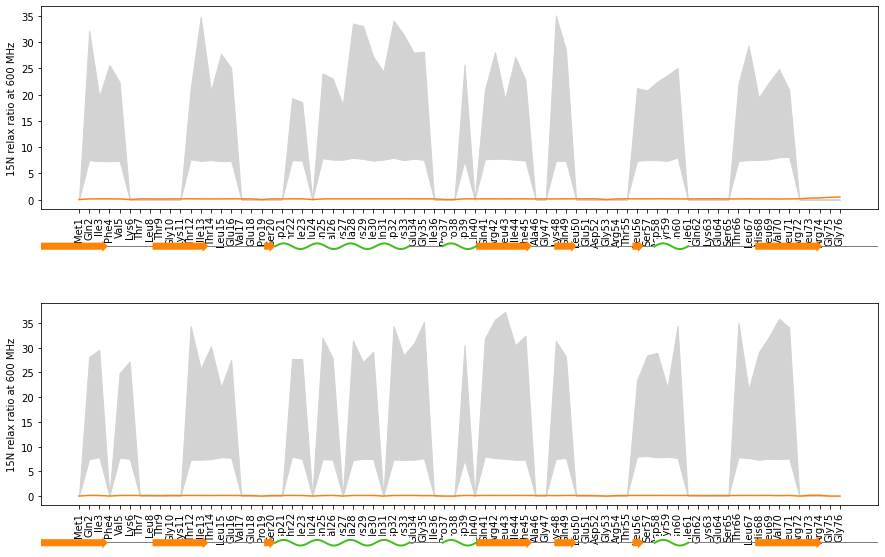

In [42]:
from nmr_plot import *

for ubq_site in ['k6', 'k29']:
    for mhz in ['600', '800']:
        plt.close('all')
        fig, (ax1, ax2,) = plt.subplots(nrows=2, figsize=(15, 10))

        for ax in [ax1, ax2]:
            ax = add_sequence_to_xaxis(ax)
            ax.set_ylabel(f'15N relax ratio at {mhz} MHz')

        (ax1, ax2) = plot_line_data((ax1, ax2), df_obs, {'rows': f'15N_relax_{mhz}', 'cols': ubq_site})
        (ax1, ax2) = plot_minmax_envelope((ax1, ax2), df_comp_w_norm, {'rows': '15N_relax_{mhz}', 'cols': ubq_site}, color='lightgrey')

        fake_legend_dict = {'line': [{'label': 'NMR experiment', 'color': 'C1'}],
                            'envelope': [{'label': 'XPLOR calculation', 'color': 'lightgrey'}]}

        plt.savefig(f"{base_image_folder}{ubq_site}_15N_{mhz}MHz_exp_vs_calculations.png")

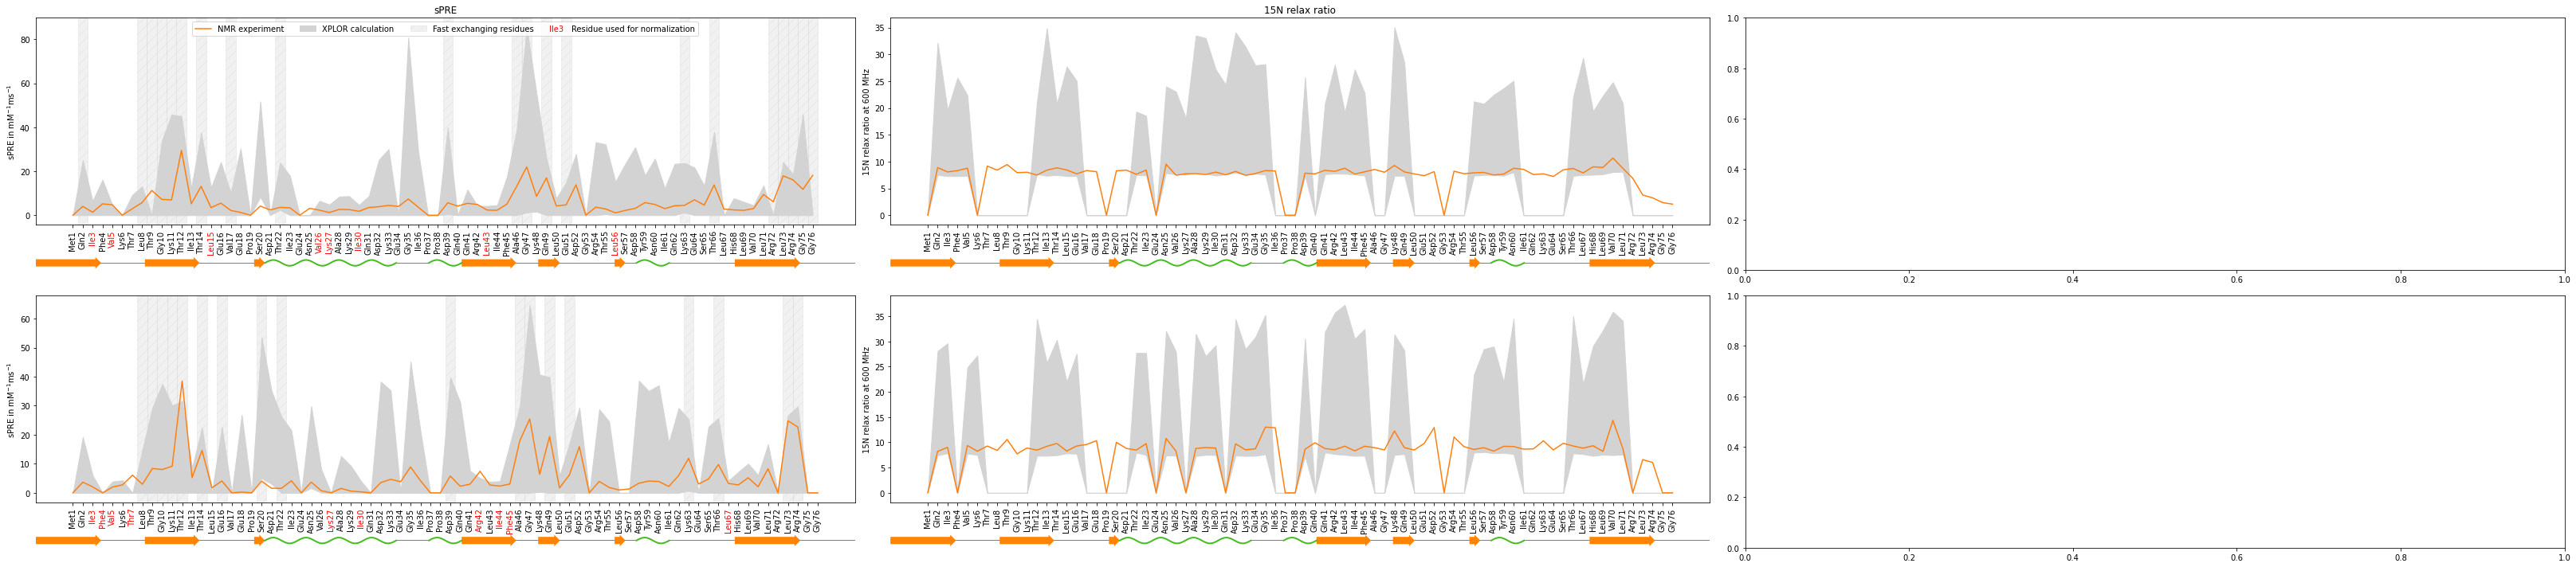

In [36]:
from nmr_plot import *
from nmr_plot import fake_legend

plt.close('all')
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(45, 10))

ax1.set_title("sPRE")
ax2.set_title("15N relax ratio")

for ax, centers in zip([ax1, ax4], [centers_prox, centers_dist - 76]):
    ax = add_sequence_to_xaxis(ax)
    ax = color_labels(ax, positions=centers)
    ax.set_ylabel(r'sPRE in $\mathrm{mM^{-1}ms^{-1}}$')
    
for ax in [ax2, ax5]:
    ax = add_sequence_to_xaxis(ax)
    ax.set_ylabel(r'15N relax ratio at 600 MHz')
    
(ax1, ax4) = plot_line_data((ax1, ax4), df_obs, {'rows': 'sPRE', 'cols': 'k6'}, color='C1')
(ax1, ax4) = plot_minmax_envelope((ax1, ax4), df_comp_w_norm, {'rows': 'sPRE', 'cols': 'k6'}, color='lightgrey')
(ax1, ax4) = plot_hatched_bars((ax1, ax4), fast_exchangers, {'cols': 'k6'})

(ax2, ax5) = plot_line_data((ax2, ax5), df_obs, {'rows': '15N_relax_600', 'cols': 'k6'})
(ax2, ax5) = plot_minmax_envelope((ax2, ax5), df_comp_w_norm, {'rows': '15N_relax_600', 'cols': 'k6'}, color='lightgrey')


fake_legend_dict = {'line': [{'label': 'NMR experiment', 'color': 'C1'}],
                    'envelope': [{'label': 'XPLOR calculation', 'color': 'lightgrey'}],
                    'hatchbar': [{'label': 'Fast exchanging residues', 'color': 'lightgrey', 'alpha': 0.3, 'hatch': '//'}],
                    'text': [{'label': 'Residue used for normalization', 'color': 'red', 'text': 'Ile3'}]}

ax1 = fake_legend(ax1, fake_legend_dict)
    
plt.tight_layout()

In [ ]:
pd.any()

In [ ]:
traj = md.load('/home/andrejb/Software/custom_tools/polyUb_builder/tetraUBQ_box/tetraUBQ_K11_0.pdb')
traj.save_gro('/home/kevin/projects/nice_images/ubq_internships/tetraUBQ_K11.gro')
import nglview as ngl
view = ngl.show_mdtraj(traj, gui=True)

In [ ]:
view

In [ ]:
cp /home/andrejb/Software/custom_tools/polyUb_builder/tetraUBQ_box/tetraUBQ_M1_0.pdb /home/kevin/projects/nice_images/ubq_internships/tetraUBQ_M1.pdb